In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from wwo_hist import retrieve_hist_data
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import datetime
from sklearn import preprocessing
from scipy import stats

bikeday = pd.read_csv('day.csv')
bikehour = pd.read_csv('hour.csv')

In [2]:
hdf = bikehour.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'is_workday', 'hum': 'humidity', 'cnt': 'users_total', 'holiday': 'is_holiday', 'atemp': 'felt_temperature', 'temp': 'temperature', 'weathersit': 'weather', 'casual': 'casual_users', 'registered': 'registered_users'})

In [3]:
hdf['season'] = hdf['season'].replace([1, 2, 3, 4], ['winter', 'spring', 'summer', 'fall'])
hdf['year'] = hdf['year'].replace([0, 1], [2011, 2012])
hdf['weekday'] = hdf['weekday'].replace([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
hdf['month'] = hdf['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
#hdf['weather'] = hdf['weather'].replace([1, 2, 3, 4], ['A', 'B', 'C', 'D'])
hdf['is_holiday'] = hdf['is_holiday'].replace([1, 0], [True, False])
hdf['is_workday'] = hdf['is_workday'].replace([1, 0], [True, False])
hdf['is_weekend'] = np.where((hdf['weekday'] == 'Saturday') | (hdf['weekday'] == 'Sunday'), True, False)
hdf.season = hdf.season.astype('category')
hdf.month = hdf.month.astype('category')
hdf.weekday = hdf.weekday.astype('category')

In [ ]:
#Download weather data using wwo_hist (just for reference):
# frequency=1
#start_date = '01-JAN-2011'
#end_date = '31-DEC-2012'
#api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
#location_list = ['washington']

#hist_weather_data = retrieve_hist_data(api_key,
#                                location_list,
#                                start_date,
#                                end_date,
#                                frequency,
#                                location_label = False,
#                                export_csv = True,
#                                store_df = True) 

In [4]:
washdf = pd.read_csv("washington.csv")
washdf['date_time'] = washdf['date_time'].astype('datetime64')
wash_sel_df = washdf[['date_time', 'totalSnow_cm', 'WindGustKmph', 'cloudcover', 'precipMM', 'visibility']]

In [5]:
scaler = MinMaxScaler() 

column_names_to_normalize = ['totalSnow_cm', 'WindGustKmph', 'cloudcover', 'precipMM', 'visibility']
x = wash_sel_df[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
wash_norm = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = wash_sel_df.index)
wash_sel_df[column_names_to_normalize] = wash_norm

/home/karsten/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [6]:
hdf['date'] = hdf['date'].astype('datetime64')
hdf['date_time'] = pd.to_datetime(hdf.date) + pd.to_timedelta(hdf.hour, unit='h')

In [7]:
capital_df = pd.merge(hdf, wash_sel_df, on='date_time')

In [8]:
capital_df = capital_df.drop(columns=['date_time'])

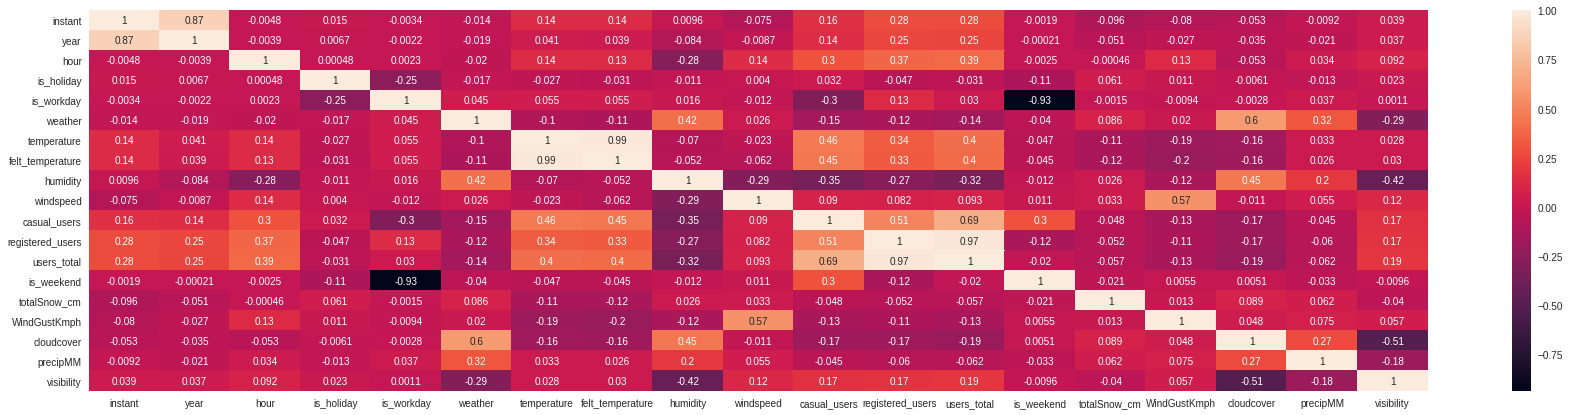

In [9]:
corr_mat = capital_df.corr()
plt.figure(figsize=(30,7))
sns.heatmap(corr_mat, annot = True)
#plt.savefig("correlation.png")
plt.show()

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

hdf_sel = hdf[['season','year','month','hour','weekday','weather','temperature','felt_temperature','windspeed','users_total']]
#hdf_sel = hdf[['season','year','month','hour','is_holiday','weekday','is_workday','weather','temperature','felt_temperature','windspeed','users_total','is_weekend']]
X = hdf_sel.drop(columns = ['users_total'])
y = hdf_sel['users_total']
#### split the dataset into train and test sets
###X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
## one-hot encode input variables
#onehot_encoder = OneHotEncoder()
#onehot_encoder.fit(X_train)
#X_train = pd.get_dummies(X_train)
#X_test = pd.get_dummies(X_test)
X = pd.get_dummies(X)
#y = pd.get_dummies(y)
#y_test = pd.get_dummies(y_test)
# define the model
model = AdaBoostRegressor()
###We do not need to call the fit method separately while using cross validation, the cross_val_score method fits the data itself while implementing the cross-validation on data.
# fit on the training set
#model.fit(X_train, y_train)
## predict on test set
#yhat = model.predict(X_test)
## evaluate predictions
#accuracy = accuracy_score(y_test, yhat)
#print('Accuracy: %.2f' % (accuracy*100))
score = cross_val_predict(model, X, y, cv=10)
#accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=10)
#accuracy = cross_val_score(model, X, y, scoring='explained_variance', cv=10)
print(score)
#get the mean of each fold 
# All scorer objects follow the convention that higher return values are better than lower return values.
#print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[ 62.12765957  50.24622642  46.4273224  ... 217.54896142 175.59259259
 175.59259259]


In [11]:
capital_df_sel = capital_df[['windspeed','totalSnow_cm' ,'WindGustKmph','cloudcover','humidity','precipMM','visibility','season','year','month','hour','weekday','weather','temperature','felt_temperature', 'users_total']]

X = capital_df_sel.drop(columns = ['users_total'])
y = capital_df_sel['users_total']

X = pd.get_dummies(X)
#y = pd.get_dummies(y)

model = AdaBoostRegressor()
#accuracy = cross_val_score(model, X, y, scoring='explained_variance', cv=10)
score = cross_val_score(model, X, y, cv=10)
print(score)
#print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[-3.03233611  0.38156017  0.3586179   0.49156869  0.3701681   0.28824765
  0.59554488  0.36078758  0.5874805   0.5648835 ]


In [13]:
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import OneHotEncoder

capital_df_sel = capital_df[['windspeed','totalSnow_cm' ,'WindGustKmph','cloudcover','humidity','precipMM','visibility','season','year','month','hour','weekday','weather','temperature','felt_temperature','users_total']]


X = capital_df_sel.drop(columns = ['users_total'])
y = capital_df_sel['users_total']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
#X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X,y,test_size=0.33,random_state =23)
#regr=LazyRegressor(verbose=0,predictions=True)
#models_r,predictions_r = regr.fit(X_train1, X_test1, Y_train1, Y_test1)
# fit and train the model 

#print(models)

100%|██████████| 42/42 [01:21<00:00,  1.95s/it]


In [14]:
print(models)

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
XGBRegressor                                 0.93       0.93   45.65   
ExtraTreesRegressor                          0.93       0.93   45.94   
HistGradientBoostingRegressor                0.93       0.93   46.23   
LGBMRegressor                                0.93       0.93   46.26   
RandomForestRegressor                        0.92       0.92   49.43   
BaggingRegressor                             0.91       0.91   52.32   
DecisionTreeRegressor                        0.84       0.84   70.56   
ExtraTreeRegressor                           0.83       0.83   72.70   
GradientBoostingRegressor                    0.80       0.81   78.81   
MLPRegressor                                 0.63       0.63  108.39   
AdaBoostRegressor                            0.58       0.59  114.75   
GaussianProcessRegressor                     0.48       0.49  12

In [14]:
print(predictions)

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
XGBRegressor                                 0.93       0.93   45.65   
ExtraTreesRegressor                          0.93       0.93   45.94   
HistGradientBoostingRegressor                0.93       0.93   46.23   
LGBMRegressor                                0.93       0.93   46.26   
RandomForestRegressor                        0.92       0.92   49.43   
BaggingRegressor                             0.91       0.91   52.32   
DecisionTreeRegressor                        0.84       0.84   70.56   
ExtraTreeRegressor                           0.83       0.83   72.70   
GradientBoostingRegressor                    0.80       0.81   78.81   
MLPRegressor                                 0.63       0.63  108.39   
AdaBoostRegressor                            0.58       0.59  114.75   
GaussianProcessRegressor                     0.48       0.49  12

In [15]:
hdf_sel = hdf[['season','year','month','hour','weekday','weather','temperature','felt_temperature','windspeed','users_total']]

X = hdf_sel.drop(columns = ['users_total'])
y = hdf_sel['users_total']

X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

#model = AdaBoostRegressor()

#score = cross_val_predict(model, X, y, cv=10)

#print(score)

100%|██████████| 42/42 [01:16<00:00,  1.83s/it]


In [16]:
print(models)

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
XGBRegressor                                 0.93       0.93  47.19   
HistGradientBoostingRegressor                0.93       0.93  48.24   
LGBMRegressor                                0.93       0.93  48.41   
ExtraTreesRegressor                          0.92       0.92  50.05   
RandomForestRegressor                        0.92       0.92  51.57   
BaggingRegressor                             0.90       0.91  55.00   
DecisionTreeRegressor                        0.85       0.85  69.83   
ExtraTreeRegressor                           0.83       0.83  72.74   
GradientBoostingRegressor                    0.80       0.80  79.41   
MLPRegressor                                 0.61       0.62 110.76   
AdaBoostRegressor                            0.58       0.58 115.22   
KNeighborsRegressor                          0.51       0.51 125.20   
Poisso

In [44]:
ddf = bikeday.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'is_workday', 'hum': 'humidity', 'cnt': 'users_total', 'holiday': 'is_holiday', 'atemp': 'felt_temperature', 'temp': 'temperature', 'weathersit': 'weather', 'casual': 'casual_users', 'registered': 'registered_users'})
ddf['season'] = ddf['season'].replace([1, 2, 3, 4], ['winter', 'spring', 'summer', 'fall'])
ddf['year'] = ddf['year'].replace([0, 1], [2011, 2012])
ddf['weekday'] = ddf['weekday'].replace([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
ddf['month'] = ddf['month'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
#ddf['weather'] = hdf['weather'].replace([1, 2, 3, 4], ['A', 'B', 'C', 'D'])
ddf['is_holiday'] = hdf['is_holiday'].replace([1, 0], [True, False])
ddf['is_workday'] = hdf['is_workday'].replace([1, 0], [True, False])
ddf['date'] = ddf['date'].astype('datetime64')
ddf['is_weekend'] = np.where((ddf['weekday'] == 'Saturday') | (ddf['weekday'] == 'Sunday'), True, False)
ddf.season = ddf.season.astype('category')
ddf.month = ddf.month.astype('category')
ddf.weekday = ddf.weekday.astype('category')

In [45]:
ddf = ddf.rename(columns={'date': 'date_time'})

In [46]:
ddf = ddf.drop(columns=['humidity'])

In [61]:
##os.mkdir('daily')
##os.chdir('daily')

#frequency=24
#start_date = '01-JAN-2011'
#end_date = '31-DEC-2012'
#api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxx'
#location_list = ['washington']

#hist_weather_data = retrieve_hist_data(api_key,
#                                location_list,
#                                start_date,
#                                end_date,
#                                frequency,
#                                location_label = False,
#                                export_csv = True,
#                                store_df = True)



Retrieving weather data for washington


Currently retrieving data for washington: from 2011-01-01 to 2011-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.767155
Currently retrieving data for washington: from 2011-02-01 to 2011-02-28
Time elapsed (hh:mm:ss.ms) 0:00:03.495881
Currently retrieving data for washington: from 2011-03-01 to 2011-03-31
Time elapsed (hh:mm:ss.ms) 0:00:05.465034
Currently retrieving data for washington: from 2011-04-01 to 2011-04-30
Time elapsed (hh:mm:ss.ms) 0:00:08.069288
Currently retrieving data for washington: from 2011-05-01 to 2011-05-31
Time elapsed (hh:mm:ss.ms) 0:00:09.802981
Currently retrieving data for washington: from 2011-06-01 to 2011-06-30
Time elapsed (hh:mm:ss.ms) 0:00:12.650106
Currently retrieving data for washington: from 2011-07-01 to 2011-07-31
Time elapsed (hh:mm:ss.ms) 0:00:15.190601
Currently retrieving data for washington: from 2011-08-01 to 2011-08-31
Time elapsed (hh:mm:ss.ms) 0:00:17.306533
Currently retrieving data for washington: fro

In [47]:
washdf_d = pd.read_csv("daily\\washington.csv")
washdf_d['date_time'] = washdf_d['date_time'].astype('datetime64')
wash_sel_d_df = washdf_d[['date_time', 'totalSnow_cm', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility']]

In [48]:
scaler = MinMaxScaler() 

column_names_to_normalize = ['totalSnow_cm', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility']
x = wash_sel_d_df[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
wash_norm_d = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = wash_sel_d_df.index)
wash_sel_d_df[column_names_to_normalize] = wash_norm_d

In [49]:
capital_d_df = pd.merge(ddf, wash_sel_d_df, on='date_time')

In [21]:
capital_d_df

,instant,date_time,season,year,month,is_holiday,weekday,is_workday,weather,temperature,...,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
0,1,2011-01-01,winter,2011,January,False,Saturday,False,A,0.344167,...,331,654,985,True,0.0,0.409091,0.90,0.983051,0.013921,0.555556
1,2,2011-01-02,winter,2011,January,False,Sunday,False,A,0.363478,...,131,670,801,True,0.0,0.409091,0.74,0.881356,0.051624,0.666667
2,3,2011-01-03,winter,2011,January,False,Monday,False,A,0.196364,...,120,1229,1349,False,0.0,0.250000,0.03,0.254237,0.000000,1.000000
3,4,2011-01-04,winter,2011,January,False,Tuesday,False,A,0.200000,...,108,1454,1562,False,0.0,0.295455,0.10,0.406780,0.000000,1.000000
4,5,2011-01-05,winter,2011,January,False,Wednesday,False,A,0.226957,...,82,1518,1600,False,0.0,0.204545,0.16,0.474576,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,winter,2012,December,False,Thursday,True,A,0.254167,...,247,1867,2114,False,0.0,0.704545,0.28,0.677966,0.004060,1.000000
727,728,2012-12-28,winter,2012,December,False,Friday,True,A,0.253333,...,644,2451,3095,False,0.0,0.181818,0.25,0.644068,0.000000,1.000000
728,729,2012-12-29,winter,2012,December,False,Saturday,True,A,0.253333,...,159,1182,1341,True,0.0,0.295455,0.68,0.813559,0.015661,0.777778
729,730,2012-12-30,winter,2012,December,False,Sunday,True,A,0.255833,...,364,1432,1796,True,0.0,0.613636,0.10,0.593220,0.000000,1.000000


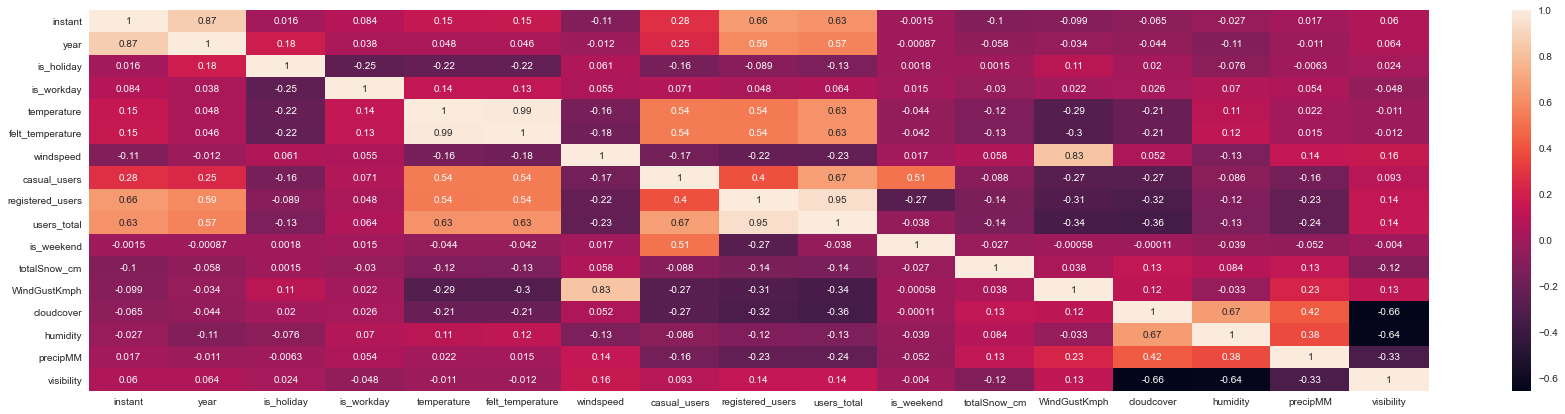

In [22]:
corr_mat_d = capital_d_df.corr()
plt.figure(figsize=(30,7))
sns.heatmap(corr_mat_d, annot = True)
#plt.savefig("correlation.png")
plt.show()

<AxesSubplot:>

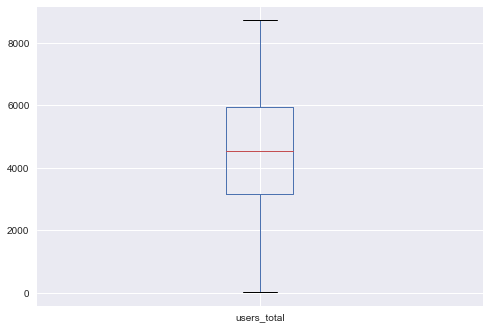

In [113]:
capital_d_df.users_total.plot.box()

<AxesSubplot:>

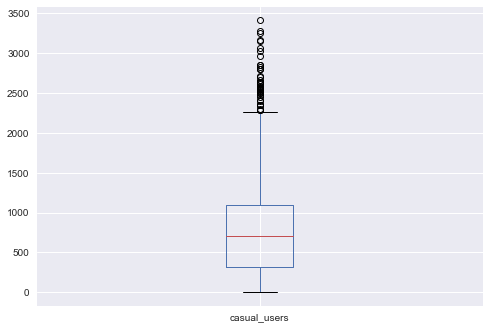

In [114]:
capital_d_df.casual_users.plot.box()

In [116]:
capital_d_df['casual_users'].sum()

620017

In [117]:
capital_d_df['registered_users'].sum()

2672662

In [23]:
capital_d_df.loc[capital_d_df['casual_users'] > 2300]

,instant,date_time,season,year,month,is_holiday,weekday,is_workday,weather,temperature,...,casual_users,registered_users,users_total,is_weekend,totalSnow_cm,WindGustKmph,cloudcover,humidity,precipMM,visibility
148,149,2011-05-29,spring,2011,May,False,Sunday,True,B,0.667500,...,2355,2433,4788,True,0.0,0.159091,0.44,0.762712,0.000580,0.666667
184,185,2011-07-04,summer,2011,July,False,Monday,False,A,0.726667,...,3065,2978,6043,False,0.0,0.136364,0.25,0.610169,0.002900,0.888889
196,197,2011-07-16,summer,2011,July,False,Saturday,False,A,0.686667,...,2418,3505,5923,True,0.0,0.204545,0.05,0.559322,0.000000,0.888889
246,247,2011-09-04,summer,2011,September,False,Sunday,True,B,0.709167,...,2521,2419,4940,True,0.0,0.272727,0.29,0.745763,0.001740,0.777778
281,282,2011-10-09,fall,2011,October,False,Sunday,True,A,0.540833,...,2397,3114,5511,True,0.0,0.000000,0.01,0.576271,0.000000,1.000000
441,442,2012-03-17,winter,2012,March,False,Saturday,True,A,0.514167,...,3155,4681,7836,True,0.0,0.159091,0.29,0.796610,0.008121,0.888889
447,448,2012-03-23,spring,2012,March,False,Friday,True,B,0.601667,...,2469,5893,8362,False,0.0,0.159091,0.10,0.711864,0.010441,0.666667
455,456,2012-03-31,spring,2012,March,False,Saturday,True,B,0.424167,...,2301,3934,6235,True,0.0,0.250000,0.69,0.779661,0.011601,0.888889
456,457,2012-04-01,spring,2012,April,False,Sunday,True,B,0.425833,...,2347,3694,6041,True,0.0,0.136364,0.45,0.711864,0.017401,0.888889
462,463,2012-04-07,spring,2012,April,False,Saturday,True,A,0.437500,...,3252,3605,6857,True,0.0,0.363636,0.00,0.186441,0.000000,1.000000


<AxesSubplot:>

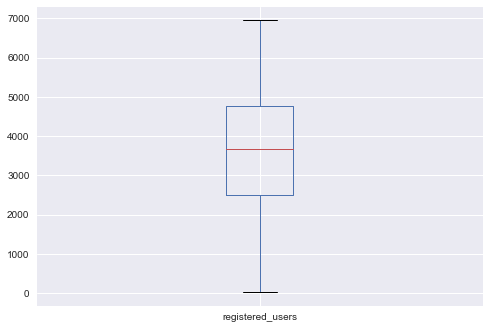

In [115]:
capital_d_df.registered_users.plot.box()

In [ ]:
enc_ddf = pd.get_dummies(ddf)

xd = enc_ddf.drop(columns = ['users_total', 'registered_users', 'casual_users'])
yd = enc_ddf['users_total']

ada = AdaBoostRegressor()
ada.fit(xd,yd)

In [ ]:
enc_d_cap = pd.get_dummies(capital_d_df)

xxd = enc_cap.drop(columns = ['users_total', 'registered_users', 'casual_users'])
yyd = enc_cap['users_total']

ada = AdaBoostRegressor()
ada.fit(xxd,yyd)